<a target="_blank" href="https://colab.research.google.com/github/BonnenLab/U19-preliminary-data-analysis/blob/main/simple-image-stats-mouse.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

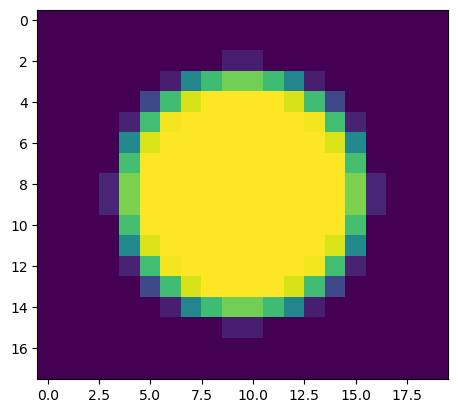

In [7]:
import h5py
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import math
import pyrtools as pt
from scipy.signal import fftconvolve
from math import pi
from tqdm import tqdm


# helper functions

def crop_central_square(img):
    width = min(img.shape)
    x = int(img.shape[0]/2 - width/2)
    y = int(img.shape[1]/2 - width/2)
    crop_img = img[x:x+width, y:y+width]
    return crop_img
    
    
    
def coswin(n, inner_radius, outer_radius):
# % COSWIN - makes a circular window with cosine taper
# %
# % usage:
# %	COSWIN(N, IR, OR) makes a raised pillbox inside a matrix of size N with
# %   cosinusoidal taper from IR (inside radius) to OR.
# %   IR should be smaller than OR (obviously), and OR should be smaller than
# %   N/2
# %

    if (outer_radius)> min(n)/2:
        raise(ValueError('radii must be < half the window diameter'))

    r2rad = (math.pi/2)*(1/(outer_radius-inner_radius)); # circle radius to radians 
    
    
    nx,ny = n
    x = nx*np.linspace(-.5, .5, nx)
    y = ny*np.linspace(-.5, .5, ny)
    xv, yv = np.meshgrid(x, y)
    h = np.sqrt(xv**2+yv**2)
    W = np.ones(xv.shape)
    
    
    # set cosine ring
    idx = (h>inner_radius) & (h<=outer_radius)
    vals = np.cos((h-inner_radius)*r2rad)
    W[idx] = vals[idx]
    
    # set outer part to zero
    idx2 = h>outer_radius;
    W[idx2] = 0;
    return W.T

cwin=coswin((18,20),5,7)
plt.imshow(cwin)
plt.show()

In [2]:
f = h5py.File('data/ModelData_070921_J553RT_fm1_dt050_rawWorldCam_4ds.h5', 'r')

In [3]:
# here are the available variables
f.keys()

<KeysViewHDF5 ['model_active', 'model_eyerad', 'model_gz', 'model_nsp', 'model_phi', 'model_pitch', 'model_roll', 'model_speed', 'model_t', 'model_th', 'model_vid_sm', 'model_vid_sm_shift', 'unit_nums']>

In [21]:
# we're going to get the video frames that have been rotated
frames = f['model_vid_sm_shift'] # Note: the frames seem to range pixel values from -2 to 2.  This is fairly non-standard

# mask them with a cosine window and crop them
masked_and_cropped = []

for img in frames:
    
    img = img/2 + .5 # setting image range to [0,1],  from [-2,2]
    
    # create cosine window to mask the image
    cwin=coswin(img.shape,12,14)
    masked = cwin*img
    
    # crop the central square
    cropped = crop_central_square(masked)
    masked_and_cropped.append(cropped)
    
frames = np.stack(masked_and_cropped)

frames.shape
    

(54354, 30, 30)

Text(0.5, 0, 'RMS contrast (std(pixels))')

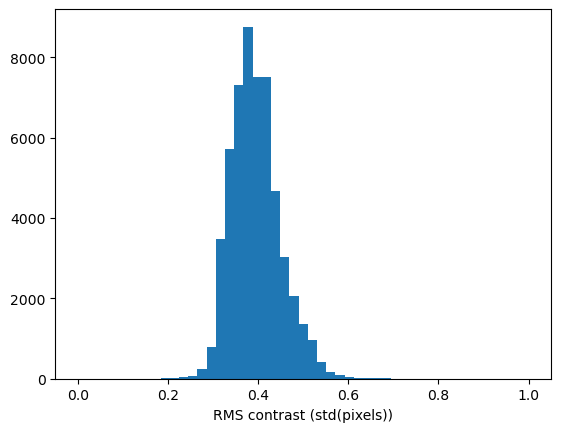

In [23]:
#  Let's try calculating global RMS contrast on all frames
def rms_contrast(img):
    # calculate contrast
    contrast = np.std(img)
    return contrast
    
rms = []
for frame in frames:
    rms.append(rms_contrast(frame))

plt.hist(rms,np.linspace(0,1,50))
plt.xlabel('RMS contrast (std(pixels))')



In [26]:
# Let's do girshick orientation counts.  (04/04/24 -- this takes at least 1 min on a fairly high power macbook pro)
# (see https://www.nature.com/articles/nn.2831 and 
# https://github.com/BonnenLab/image_stats/blob/main/girshick.py)

def girshick_orientation_counts(img,height):
    
    # make filters
    gp = np.array([0.037659, 0.249153, 0.426375, 0.249153, 0.037659])
    gp = gp.reshape((1,5))
    gd = np.array([-0.109604, -0.276691, 0.000000, 0.276691, 0.109604])
    gd = gd.reshape((1,5))
    bfilt = np.array([1, 2, 1])/4
    bfilt = bfilt.reshape(3, 1)

    # get image pyramid
    Gpyr = pt.pyramids.GaussianPyramid(img,height)

    all_hists = [] # list of the 6 histograms for the current frame
    for j in range(height):
        # derivative in x direction
        Ix = pt.pyramids.c.wrapper.corrDn(pt.pyramids.c.wrapper.corrDn(Gpyr.pyr_coeffs[j, 0], gd), gp.T)
        # derivative in y direction
        Iy = pt.pyramids.c.wrapper.corrDn(pt.pyramids.c.wrapper.corrDn(Gpyr.pyr_coeffs[j, 0], gp), gd.T)
    
        Mxx = fftconvolve(fftconvolve(Ix*Ix, bfilt, 'valid'), bfilt.T, 'valid')
        Myy = fftconvolve(fftconvolve(Iy*Iy, bfilt, 'valid'), bfilt.T, 'valid')
        Mxy = fftconvolve(fftconvolve(Ix*Iy, bfilt, 'valid'), bfilt.T, 'valid');
    
        term1   = (Mxx + Myy)/2
        term2   = (term1**2 - (Mxx*Myy - Mxy**2)) ** .5
    
        eps = 2.2204e-16
    
        ev1 = term1 + term2
        ev2 = term1 - term2
        ori = np.arctan2(Mxx-ev2, Mxy)-pi/2
        energy = ev1 + ev2
        orientedness  =  ((ev1-ev2)/(ev1+ev2+eps)) **2

        height, width = orientedness.shape[:2]
        
        # create circle mask to prevent artifacts
        rad = .9*height/2
        x = np.linspace(-width/2, width/2-1, width)
        y = np.linspace(-height/2, height/2-1, height)
        xv, yv = np.meshgrid(x, y)
        ind_central = (xv**2 + yv**2)**.5 > rad
    
        ind1 = energy < max(np.quantile(energy[:],.68), 1e-4)
        ind2 = orientedness < .8
        ori_thresholded = ori
        ori_thresholded[ind1] = np.nan
        ori_thresholded[ind2] = np.nan
        ori_thresholded[ind_central] = np.nan
    
        ori_deg = ori_thresholded.flatten() * (180/pi)
        
        # bin orientations
        h = np.histogram(ori_deg, bins=35,range=(-87.5,87.5))
        
        ind_circ_lower = ori_deg < -87.5
        ind_circ_upper = ori_deg > 87.5 
    
        fs = list(h[0])
        fs.insert(0, np.sum(ori_deg[ind_circ_lower]/ori_deg[ind_circ_lower]) + np.sum(ori_deg[ind_circ_upper]/ori_deg[ind_circ_upper]))
        fs.append(np.sum(ori_deg[ind_circ_lower]/ori_deg[ind_circ_lower]) + np.sum(ori_deg[ind_circ_upper]/ori_deg[ind_circ_upper]))
        fs = np.array(fs)
        all_hists.append(fs)
        
    return all_hists

all_hists = []

for ii in tqdm(range(frames.shape[0])):
    hists = girshick_orientation_counts(frames[ii],3)
    all_hists.append(np.array(hists))
    

orientation = np.stack(all_hists)



100%|██████████████████████████████████████████████████████████████████████████| 54354/54354 [01:00<00:00, 903.45it/s]


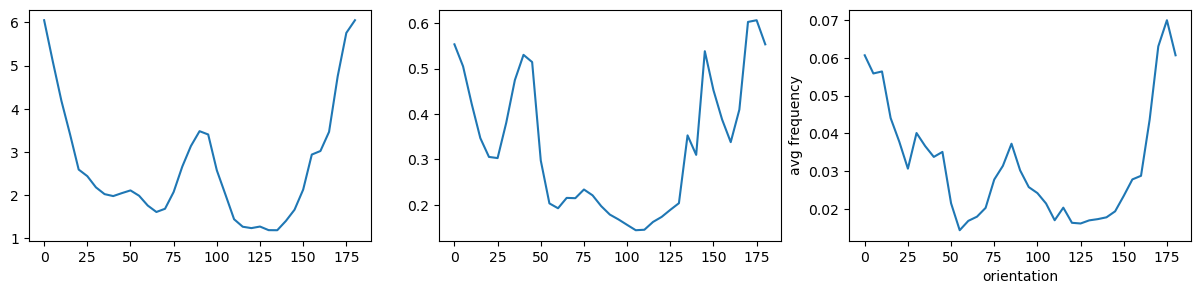

In [39]:
# average orientation statistics at 3 spatial scales
mean_oris = orientation.mean(axis=0)
fig, ax = plt.subplots(1, 3,figsize=(15, 3))
for ii in range(3):
    ax[ii].plot(np.linspace(0,180,37),mean_oris[ii])
    plt.xlabel('orientation')
    plt.ylabel('avg frequency')



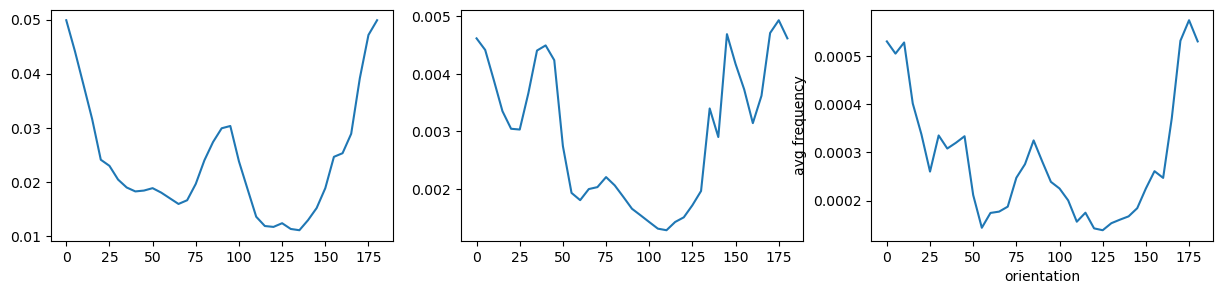

In [40]:
# normalize all histograms to get relative representation of orientations at 3 spatial scales
norm_orientations = np.stack([ori/ori.sum() for ori in orientation])
mean_oris = norm_orientations.mean(axis=0)
fig, ax = plt.subplots(1, 3,figsize=(15,3))
for ii in range(3):
    ax[ii].plot(np.linspace(0,180,37),mean_oris[ii])
    plt.xlabel('orientation')
    plt.ylabel('avg frequency')

In [ ]:
# TODO -- spatial frequency analysis